In [1]:
import sys
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./train.csv', encoding = 'big5')
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
# Convert to numeric, forcing errors to NaN and then fill NaN with 0
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
raw_data = data.to_numpy(dtype=float)

In [3]:
dayFlatten_data = np.empty([18,24*20*12])
for month in range(12):
  for day in range(20):
    dayFlatten_data[:, (month*20+day)*24:(month*20+day)*24+24] = raw_data[18*(20*month+day):18*(20*month+day+1), 0:24]

In [4]:
x = np.empty([12*471, 18*9], dtype=float)
y = np.empty([12*471, 1], dtype=float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = dayFlatten_data[:,day * 24 + hour : day * 24 + hour + 9].flatten()
            y[month * 471 + day * 24 + hour, 0] = dayFlatten_data[9, day * 24 + hour + 9]
print(x)
print(y)

[[11.1 11.2 11.4 ...  2.1  2.6  2.6]
 [11.2 11.4 11.5 ...  2.6  2.6  3.1]
 [11.4 11.5 11.6 ...  2.6  3.1  3. ]
 ...
 [23.7 24.7 24.  ...  1.   0.7  0.6]
 [24.7 24.  23.9 ...  0.7  0.6  0.7]
 [24.  23.9 23.  ...  0.6  0.7  0.7]]
[[11.]
 [10.]
 [16.]
 ...
 [32.]
 [31.]
 [30.]]


# Normalize

In [ ]:
mean_x = np.mean(x, axis = 0)
std_x = np.std(x, axis = 0)
for i in range(len(x)):
    for j in range(len(x[0])):
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

0:17.245818595339408
100:4.288645079544829
200:3.9205869142398044
300:3.7897667342757737
400:3.711401230354261
500:3.656341088169313
600:3.6148458680255544
700:3.5820796342809267
800:3.555312185298541
900:3.5328951407626485
1000:3.5137747946354474
1100:3.49723855979189
1200:3.482777675269797
1300:3.4700111991229523
1400:3.458643029215332
1500:3.44843681533539
1600:3.4392005840517355
1700:3.4307766934187987
1800:3.4230348004303046
1900:3.415866629118337
2000:3.4091819044249867
2100:3.402905110564933
2200:3.396972877762212
2300:3.391331871215793
2400:3.3859370896971
2500:3.3807504982877283
2600:3.3757399303016142
2700:3.3708782019186185
2800:3.366142391232832
2900:3.361513241684242
3000:3.3569746580082587
3100:3.352513270535355
3200:3.348118050550202
3300:3.343779965221708
3400:3.339491665208751
3500:3.3352472014127303
3600:3.331041769565827
3700:3.3268714825655237
3800:3.32273317089208
3900:3.3186242112996194
4000:3.3145423834747736
4100:3.310485753707645
4200:3.306452583977393
4300:3.3

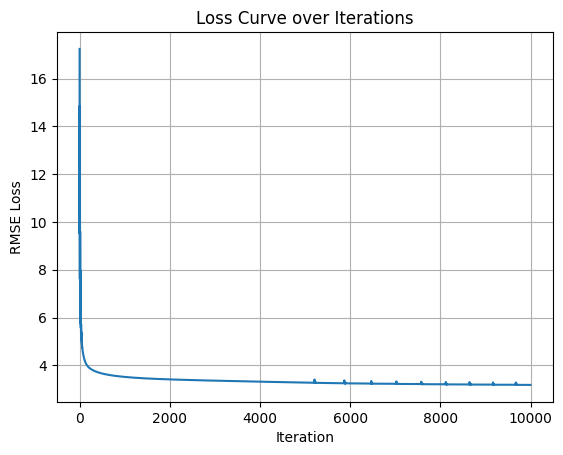

In [22]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
hyper_parameter = {
    "learning_rate" : 0.001,
    # "learning_rate" : 1e-5,
    "n_iterations" : 10000,
    "gamma1" : 0.9,
    "gamma2" : 0.999,
    "eps" : 1e-8,
}

dim = 18 * 9 + 1
w = np.zeros([dim,1])
x_b = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
# print(x_b)
m = x_b.shape[0]
grad_momentum = np.zeros_like(w)
grad_RMSProp = np.zeros_like(w)
losses = []
for i in range(hyper_parameter["n_iterations"]):
  loss = np.sqrt(np.mean(((x_b @ w) - y) ** 2))

  if np.isnan(loss) or np.isinf(loss):
    print(f"Stopping early due to numerical instability at iteration {i}")
    break
  losses.append(loss)

  if i % 100 == 0:
    print(str(i) + ':' + str(loss))

  gradient = 2 / m * (x_b.T @ (x_b @ w - y))
  grad_momentum = hyper_parameter["gamma1"] * grad_momentum + (1 - hyper_parameter["gamma1"]) * gradient
  grad_RMSProp = np.sqrt(hyper_parameter["gamma2"] * (grad_RMSProp ** 2) + (1-hyper_parameter["gamma2"]) * (gradient ** 2))
  # w = w - hyper_parameter["learning_rate"] * grad_momentum
  w = w - hyper_parameter["learning_rate"] * grad_momentum / (grad_RMSProp + hyper_parameter["eps"])

print(str(hyper_parameter["n_iterations"]) + ':' + str(loss))

np.save('weight.npy', w)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("RMSE Loss")
plt.title("Loss Curve over Iterations")
plt.grid()
plt.show()

In [16]:
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
testdata = testdata.iloc[:, 2:]
testdata[testdata == 'NR'] = 0
testdata = testdata.apply(pd.to_numeric, errors='coerce').fillna(0)
test_data = testdata.to_numpy(dtype=float)
test_x = np.empty([244, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
# for i in range(len(test_x)):
#     for j in range(len(test_x[0])):
#         if std_x[j] != 0:
#             test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([244, 1]), test_x), axis = 1).astype(float)
print(test_x.shape)

(244, 163)


In [17]:
# print(f"Shape of test_x: {test_x.shape}")
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
# ans_y
print(ans_y.shape)

(244, 1)


In [21]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['index', 'answer']
    print(header)
    csv_writer.writerow(header)
    for i in range(244):
        row = ['index_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['index', 'answer']
['index_0', np.float64(19.807387894991457)]
['index_1', np.float64(18.158415203249543)]
['index_2', np.float64(11.595742345845744)]
['index_3', np.float64(16.144492749915738)]
['index_4', np.float64(26.36134693976017)]
['index_5', np.float64(25.818844086450774)]
['index_6', np.float64(14.629559208347171)]
['index_7', np.float64(20.873283265210244)]
['index_8', np.float64(38.92416033894415)]
['index_9', np.float64(12.400055089154721)]
['index_10', np.float64(22.9687089836314)]
['index_11', np.float64(23.759675885588607)]
['index_12', np.float64(29.169740536623227)]
['index_13', np.float64(22.07980692327097)]
['index_14', np.float64(16.954626441114765)]
['index_15', np.float64(39.80911237196116)]
['index_16', np.float64(30.36327744577481)]
['index_17', np.float64(7.455044633539242)]
['index_18', np.float64(10.936306062980645)]
['index_19', np.float64(14.185034870378773)]
['index_20', np.float64(22.257877215763518)]
['index_21', np.float64(8.713163913431709)]
['index_2